# Solo usar si se quiere generar nuevo CSV

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
# Binance Client
try:
  from binance.client import Client as BinanceProvider
except ModuleNotFoundError:
  !pip install python-binance
  from binance.client import Client as BinanceProvider

# Define the ticker symbol for Bitcoin (BTC-USD)
ticker = "ETHUSDT"


# Download historical data using yfinance
api_key = "OF6SkzXI0EAcvmMWlkeUKl6YyxYIFU4pN0Bj19gaVYZcgaTt7OImXxEyvoPcDhmk"
secret_key = "tXay1BDYuSyigxvl27UQIBJbIHADaep8FT7HPO9Mb3vfmcyDkz4keEaHkpm7dcFe"
provider= BinanceProvider(api_key, secret_key, tld='us')

klines = provider.get_historical_klines(ticker,BinanceProvider.KLINE_INTERVAL_1MINUTE, "1 Jun, 2010")
bitcoin_data = pd.DataFrame(klines, columns = ["Open time", "Open", "High", "Low", "Close", "Volume", "Close time", "Quote asset volume"," Number of trades"," Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"])
bitcoin_data['Date'] = bitcoin_data['Open time'].apply(lambda x : datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
bitcoin_data['Close'] =  bitcoin_data['Close'].apply(lambda x : float(x))

bitcoin_data = bitcoin_data.drop('Open time', axis=1)
bitcoin_data = bitcoin_data.set_index("Date")

# Display the first few rows of the data
print(bitcoin_data.head())
bitcoin_data.info()


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:00
                             Open          High           Low   Close  \
Date                                                                    
2019-09-23 08:36:00  209.55000000  209.55000000  209.55000000  209.55   
2019-09-23 08:37:00  209.55000000  209.55000000  209.55000000  209.55   
2019-09-23 08:38:00  209.55000000  209.55000000  209.55000000  209.55   
2019-09-23 08:39:00  209.55000000  209.55000000  209.55000000  209.55   
2019-09-23 08:40:00  209.55000000  209.55000000  209.55000000  209.55   

                         Volume     Close time Quote asset volume  \
Date           

In [ ]:
bitcoin_data.columns = map(str.upper, bitcoin_data.columns)
bitcoin_data_subset =  bitcoin_data[["OPEN", "HIGH", "LOW", "CLOSE"]].copy()

bitcoin_data_subset = bitcoin_data_subset.rename_axis('Date')
bitcoin_data_subset.index = pd.to_datetime(bitcoin_data_subset.index)
# # Save the data to a CSV file

bitcoin_data_subset.to_csv("eth_ohlc_data.csv")


print(bitcoin_data_subset.info())
print(bitcoin_data_subset.head())
print(bitcoin_data_subset.tail())

NameError: name 'bitcoin_data' is not defined

# Solo usar para cargar desde drive

In [1]:
import pandas as pd
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive/')


# Ruta al directorio que deseas explorar, ANTES: crear acceso directo desde la raiz
directorio = '/content/drive/MyDrive/TP/notebooks/datos/eth_ohlc_data.csv'

# # Listar todos los archivos y carpetas en el directorio
# contenido = os.listdir(directorio)

# # Separar archivos y carpetas
# archivos = [elemento for elemento in contenido if os.path.isfile(os.path.join(directorio, elemento))]
# carpetas = [elemento for elemento in contenido if os.path.isdir(os.path.join(directorio, elemento))]

# # # Imprimir la lista de archivos
# print("Archivos en el directorio:")
# for archivo in archivos:
#     print(archivo)

# # Imprimir la lista de carpetas
# print("\nCarpetas en el directorio:")
# for carpeta in carpetas:
#     print(carpeta)

data = pd.read_csv(directorio)
data.info()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286238 entries, 0 to 2286237
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   OPEN    float64
 2   HIGH    float64
 3   LOW     float64
 4   CLOSE   float64
dtypes: float64(4), object(1)
memory usage: 87.2+ MB


In [2]:
#
# Event-Based Backtesting
# --Base Class (1)
#
# (c) Dr. Yves J. Hilpisch
# Artificial Intelligence in Finance
#

class BacktestingBase:
    def __init__(self, env, model, amount, ptc, ftc, verbose=False):
        self.env = env
        self.model = model
        self.initial_amount = amount
        self.current_balance = amount
        self.ptc = ptc
        self.ftc = ftc
        self.verbose = verbose
        self.units = 0
        self.trades = 0

    def get_date_price(self, bar):
        ''' Returns date and price for a given bar.
        '''
        date = str(self.env.data.index[bar])[:10]
        price = self.env.data[self.env.symbol].iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Prints the current cash balance for a given bar.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance = {self.current_balance:.2f}')

    def calculate_net_wealth(self, price):
        return self.current_balance + self.units * price

    def print_net_wealth(self, bar):
        ''' Prints the net wealth for a given bar
            (cash + position).
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.calculate_net_wealth(price)
        print(f'{date} | net wealth = {net_wealth:.2f}')

    def place_buy_order(self, bar, amount=None, units=None):
        ''' Places a buy order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
            # units = amount / price  # alternative handling
        self.current_balance -= (1 + self.ptc) * \
            units * price + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buy {units} units for {price:.10f}')
            self.print_balance(bar)

    def place_sell_order(self, bar, amount=None, units=None):
        ''' Places a sell order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
            # units = amount / price  # altermative handling
        self.current_balance += (1 - self.ptc) * \
            units * price - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | sell {units} units for {price:.4f}')
            self.print_balance(bar)

    def close_out(self, bar):
        ''' Closes out any open position at a given bar.
        '''
        date, price = self.get_date_price(bar)
        print(50 * '=')
        print(f'{date} | *** CLOSING OUT ***')
        if self.units < 0:
            self.place_buy_order(bar, units=-self.units)
        else:
            self.place_sell_order(bar, units=self.units)
        if not self.verbose:
            print(f'{date} | current balance = {self.current_balance:.2f}')
        perf = (self.current_balance / self.initial_amount - 1) * 100
        print(f'{date} | net performance [%] = {perf:.4f}')
        print(f'{date} | number of trades [#] = {self.trades}')
        print(50 * '=')

In [3]:
#
# Event-Based Backtesting
# --Base Class (2)
#
# (c) Dr. Yves J. Hilpisch
#

class BacktestingBaseRM(BacktestingBase):

    def set_prices(self, price):
        ''' Sets prices for tracking of performance.
            To test for e.g. trailing stop loss hit.
        '''
        self.entry_price = price
        self.min_price = price
        self.max_price = price

    def place_buy_order(self, bar, amount=None, units=None, gprice=None):
        ''' Places a buy order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if gprice is not None:
            price = gprice
        if units is None:
            units = int(amount / price)
        self.current_balance -= (1 + self.ptc) * units * price + self.ftc
        self.units += units
        self.trades += 1
        self.set_prices(price)
        if self.verbose:
            print(f'{date} | buy {units} units for {price:.10f}')
            self.print_balance(bar)

    def place_sell_order(self, bar, amount=None, units=None, gprice=None):
        ''' Places a sell order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if gprice is not None:
            price = gprice
        if units is None:
            units = int(amount / price)
        self.current_balance += (1 - self.ptc) * units * price - self.ftc
        self.units -= units
        self.trades += 1
        self.set_prices(price)
        if self.verbose:
            print(f'{date} | sell {units} units for {price:.10f}')
            self.print_balance(bar)

In [4]:
#
# Finance Environment
#
# (c) Dr. Yves J. Hilpisch
# Artificial Intelligence in Finance
#
import math
import random
import numpy as np
import pandas as pd


class observation_space:
    def __init__(self, n):
        self.shape = (n,)


class action_space:
    def __init__(self, n):
        self.n = n

    def sample(self):
        return random.randint(0, self.n - 1)


class Finance:
    intraday = True
    if intraday:
        url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
    else:
        url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

    def __init__(self, symbol, features, window, lags,
                 leverage=1, min_performance=0.85, min_accuracy=0.5,
                 start=0, end=None, mu=None, std=None):
        self.symbol = symbol
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.min_accuracy = min_accuracy
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self._get_data()
        self._prepare_data()

    def _get_data(self):
        # self.raw = bitcoin_data_subset
        self.raw = pd.read_csv(directorio, index_col=0,
                               parse_dates=True).dropna()
        if self.intraday:
            self.raw = self.raw.resample('30min', label='right').last()
            self.raw = pd.DataFrame(self.raw['CLOSE'])
            self.raw.columns = [self.symbol]

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data = self.data.iloc[self.start:]
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)


        #### Agregado
        self.data["Close"] = self.raw[self.symbol]
        ## RSI
        self.data["diff"] = self.data.Close.diff()

        # If the difference is greater than 0, set the 'win' column to the difference; otherwise, set it to 0
        self.data["win"] = np.where(self.data["diff"] > 0, self.data["diff"], 0)

        # If the difference is less than 0, set the 'loss' column to the absolute difference; otherwise, set it to 0
        self.data["loss"] = np.where(self.data["diff"] < 0, abs(self.data["diff"]), 0)

        # Calculate the exponential moving average of the 'win' column
        self.data["EMA_win"] = self.data.win.ewm(alpha=1 / self.window).mean()

        # Calculate the exponential moving average of the 'loss' column
        self.data["EMA_loss"] = self.data.loss.ewm(alpha=1 / self.window).mean()

        # Calculate the ratio between the exponential moving averages ('RS' column)
        self.data["RS"] = self.data.EMA_win / self.data.EMA_loss
        self.data["RSI"] = 100 - (100 / (1 + self.data["RS"]))

        mean_rsi = self.data["RSI"].mean()
        std_rsi = self.data["RSI"].std()
        self.data["RSI"] = (self.data["RSI"] - mean_rsi) / std_rsi


        # Calculate the fast exponential moving average
        self.data["ema_fast"] = self.data.Close.ewm(span=12).mean()

        # Calculate the slow exponential moving average
        self.data["ema_slow"] = self.data.Close.ewm(span=29).mean()

        # The difference between the fast and slow moving averages is another moving average called MACD
        self.data["macd"] = self.data.ema_fast - self.data.ema_slow

        # Smooth the MACD and call it the 'signal'
        self.data["signal"] = self.data.macd.ewm(span=9).mean()

        # Finally, the point of interest is the difference between the MACD and the signal
        # It is particularly interesting when it crosses zero.
        self.data["histogram"] = self.data.macd - self.data.signal
        mean_histogram = self.data["histogram"].mean()
        std_histogram = self.data["histogram"].std()
        self.data["histogram"] = (self.data["histogram"] - mean_histogram) / std_histogram


        self.data['s'] = self.data[self.symbol].rolling(self.window).mean()
        self.data['min'] = self.data[self.symbol].rolling(self.window).min()
        self.data['max'] = self.data[self.symbol].rolling(self.window).max()
        self.data['m'] = self.data['r'].rolling(self.window).mean() #momentum
        self.data['v'] = self.data['r'].rolling(self.window).std() #volatilty
        self.data.dropna(inplace=True)
        if self.mu is None:
            self.mu = self.data.mean()
            self.std = self.data.std()
        self.data_ = (self.data - self.mu) / self.std
        self.data['d'] = np.where(self.data['r'] > 0, 0, 1)
        self.data['d'] = self.data['d'].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]

    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                              self.lags:self.bar]

    def get_state(self, bar):
        return self.data_[self.features].iloc[bar - self.lags:bar]

    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar -
                                               self.lags:self.bar]
        return state.values

    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_1 = 1 if correct else 0
        reward_2 = abs(ret) if correct else -abs(ret)
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)
        if self.bar >= len(self.data):
            done = True
        elif reward_1 == 1:
            done = False
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 15):
            done = True
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.lags + 15):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state.values, reward_1 + reward_2 * 5, done, info

In [5]:
#
# Financial Q-Learning Agent
#
# (c) Dr. Yves J. Hilpisch
# Artificial Intelligence in Finance
#
import os
import random
import logging
import numpy as np
from pylab import plt, mpl
from collections import deque
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from keras.layers import Dense, Dropout
from keras.models import Sequential

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'


def set_seeds(seed=100):
    ''' Function to set seeds for all
        random number generators.
    '''
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


class TradingBot:
    def __init__(self, hidden_units, learning_rate, learn_env,
                 valid_env=None, val=True, dropout=False):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.val = val
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99
        self.learning_rate = learning_rate
        self.gamma = 0.5
        self.batch_size = 128
        self.max_treward = 0
        self.averages = list()
        self.trewards = []
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.model = self._build_model(hidden_units,
                             learning_rate, dropout)

    def _build_model(self, hu, lr, dropout):
        ''' Method to create the DNN model.
        '''
        model = Sequential()
        model.add(Dense(hu, input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
            activation='relu'))
        if dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(2, activation='linear'))
        model.compile(
            loss='mse',
            optimizer=keras.optimizers.legacy.RMSprop(learning_rate=lr)
        )
        return model

    def act(self, state):
        ''' Method for taking action based on
            a) exploration
            b) exploitation
        '''
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state)[0, 0]
        return np.argmax(action)

    def replay(self):
        ''' Method to retrain the DNN model based on
            batches of memorized experiences.
        '''
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0, 0])
            target = self.model.predict(state)
            target[0, 0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        ''' Method to train the DQL agent.
        '''
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = self.learn_env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.learn_env.lags,
                                         self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                    next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                       av, self.max_treward), end='\r')
                    break
            if self.val:
                self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def validate(self, e, episodes):
        ''' Method to validate the performance of the
            DQL agent.
        '''
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
        for _ in range(10000):
            action = np.argmax(self.model.predict(state)[0, 0])
            next_state, reward, done, info = self.valid_env.step(action)
            state = np.reshape(next_state, [1, self.valid_env.lags,
                                            self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % int(episodes / 10) == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4d} | perf: {:5.3f} | eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, treward,
                                       perf, self.epsilon))
                break


def plot_treward(agent):
    ''' Function to plot the total reward
        per training eposiode.
    '''
    plt.figure(figsize=(10, 6))
    x = range(1, len(agent.averages) + 1)
    y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
    plt.plot(x, agent.averages, label='moving average')
    plt.plot(x, y, 'r--', label='regression')
    plt.xlabel('episodes')
    plt.ylabel('total reward')
    plt.legend()


def plot_performance(agent):
    ''' Function to plot the financial gross
        performance per training episode.
    '''
    plt.figure(figsize=(10, 6))
    x = range(1, len(agent.performances) + 1)
    y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
    plt.plot(x, agent.performances[:], label='training')
    plt.plot(x, y, 'r--', label='regression (train)')
    if agent.val:
        y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
        plt.plot(x, agent.vperformances[:], label='validation')
        plt.plot(x, y_, 'r-.', label='regression (valid)')
    plt.xlabel('episodes')
    plt.ylabel('gross performance')
    plt.legend()

In [6]:
#
# Event-Based Backtesting
# --Trading Bot Backtester
# (incl. Risk Management)
#
# (c) Dr. Yves J. Hilpisch
#
import numpy as np
import pandas as pd

class TBBacktesterRM(BacktestingBaseRM):
    def _reshape(self, state):
        ''' Helper method to reshape state objects.
        '''
        return np.reshape(state, [1, self.env.lags, self.env.n_features])

    def backtest_strategy(self, sl=None, tsl=None, tp=None,
                          wait=5, guarantee=False):
        ''' Event-based backtesting of the trading bot's performance.
            Incl. stop loss, trailing stop loss and take profit.
        '''
        self.units = 0
        self.position = 0
        self.trades = 0
        self.sl = sl
        self.tsl = tsl
        self.tp = tp
        self.wait = 0
        self.current_balance = self.initial_amount
        self.net_wealths = list()
        for bar in range(self.env.lags, len(self.env.data)):
            self.wait = max(0, self.wait - 1)
            date, price = self.get_date_price(bar)
            if self.trades == 0:
                print(50 * '=')
                print(f'{date} | *** START BACKTEST ***')
                self.print_balance(bar)
                print(50 * '=')

            # stop loss order
            if sl is not None and self.position != 0:
                rc = (price - self.entry_price) / self.entry_price
                if self.position == 1 and rc < -self.sl:
                    print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 - self.sl)
                        print(f'*** STOP LOSS (LONG  | {-self.sl:.4f}) ***')
                    else:
                        print(f'*** STOP LOSS (LONG  | {rc:.4f}) ***')
                    self.place_sell_order(bar, units=self.units, gprice=price)
                    self.wait = wait
                    self.position = 0
                elif self.position == -1 and rc > self.sl:
                    print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 + self.sl)
                        print(f'*** STOP LOSS (SHORT | -{self.sl:.4f}) ***')
                    else:
                        print(f'*** STOP LOSS (SHORT | -{rc:.4f}) ***')
                    self.place_buy_order(bar, units=-self.units, gprice=price)
                    self.wait = wait
                    self.position = 0

            # trailing stop loss order
            if tsl is not None and self.position != 0:
                self.max_price = max(self.max_price, price)
                self.min_price = min(self.min_price, price)
                rc_1 = (price - self.max_price) / self.entry_price
                rc_2 = (self.min_price - price) / self.entry_price
                if self.position == 1 and rc_1 < -self.tsl:
                    print(50 * '-')
                    print(f'*** TRAILING SL (LONG  | {rc_1:.4f}) ***')
                    self.place_sell_order(bar, units=self.units)
                    self.wait = wait
                    self.position = 0
                elif self.position == -1 and rc_2 < -self.tsl:
                    print(50 * '-')
                    print(f'*** TRAILING SL (SHORT | {rc_2:.4f}) ***')
                    self.place_buy_order(bar, units=-self.units)
                    self.wait = wait
                    self.position = 0

            # take profit order
            if tp is not None and self.position != 0:
                rc = (price - self.entry_price) / self.entry_price
                if self.position == 1 and rc > self.tp:
                    print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 + self.tp)
                        print(f'*** TAKE PROFIT (LONG  | {self.tp:.4f}) ***')
                    else:
                        print(f'*** TAKE PROFIT (LONG  | {rc:.4f}) ***')
                    self.place_sell_order(bar, units=self.units, gprice=price)
                    self.wait = wait
                    self.position = 0
                elif self.position == -1 and rc < -self.tp:
                    print(50 * '-')
                    if guarantee:
                        price = self.entry_price * (1 - self.tp)
                        print(f'*** TAKE PROFIT (SHORT | {self.tp:.4f}) ***')
                    else:
                        print(f'*** TAKE PROFIT (SHORT | {-rc:.4f}) ***')
                    self.place_buy_order(bar, units=-self.units, gprice=price)
                    self.wait = wait
                    self.position = 0

            state = self.env.get_state(bar)
            action = np.argmax(self.model.predict(
                self._reshape(state.values))[0, 0])
            position = 1 if action == 1 else -1
            if self.position in [0, -1] and position == 1 and self.wait == 0:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING LONG ***')
                if self.position == -1:
                    self.place_buy_order(bar - 1, units=-self.units)
                self.place_buy_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = 1
            elif self.position in [0, 1] and position == -1 and self.wait == 0:
                if self.verbose:
                    print(50 * '-')
                    print(f'{date} | *** GOING SHORT ***')
                if self.position == 1:
                    self.place_sell_order(bar - 1, units=self.units)
                self.place_sell_order(bar - 1, amount=self.current_balance)
                if self.verbose:
                    self.print_net_wealth(bar)
                self.position = -1
            self.net_wealths.append((date, self.calculate_net_wealth(price)))
        self.net_wealths = pd.DataFrame(self.net_wealths,
                                        columns=['date', 'net_wealth'])
        self.net_wealths.set_index('date', inplace=True)
        self.net_wealths.index = pd.DatetimeIndex(self.net_wealths.index)
        self.close_out(bar)

In [7]:
symbol = 'BTC'
features = ['r', 's', 'm', 'v','min','max','RSI','histogram']

In [8]:
a = 0
b = 55000
c = 10500
d = 5000

In [9]:
learn_env = Finance(symbol, features, window=10, lags=6,
                 leverage=1, min_performance=0.85,
                 start=a, end=a + b, mu=None, std=None)

In [10]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55000 entries, 2019-09-24 14:00:00 to 2022-11-15 00:00:00
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BTC        55000 non-null  float64
 1   r          55000 non-null  float64
 2   Close      55000 non-null  float64
 3   diff       55000 non-null  float64
 4   win        55000 non-null  float64
 5   loss       55000 non-null  float64
 6   EMA_win    55000 non-null  float64
 7   EMA_loss   55000 non-null  float64
 8   RS         55000 non-null  float64
 9   RSI        55000 non-null  float64
 10  ema_fast   55000 non-null  float64
 11  ema_slow   55000 non-null  float64
 12  macd       55000 non-null  float64
 13  signal     55000 non-null  float64
 14  histogram  55000 non-null  float64
 15  s          55000 non-null  float64
 16  min        55000 non-null  float64
 17  max        55000 non-null  float64
 18  m          55000 non-null  float64
 19  v          

In [11]:
learn_env.data.tail()

,BTC,r,Close,diff,win,loss,EMA_win,EMA_loss,RS,RSI,...,ema_slow,macd,signal,histogram,s,min,max,m,v,d
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-14 22:00:00,1227.35,0.002701,1227.35,3.31,3.31,0.00,3.005950,3.656148,0.822163,-0.411697,...,1234.546447,-4.846509,-1.197517,-0.792648,1228.952,1213.55,1243.79,-0.000264,0.006814,0
2022-11-14 22:30:00,1219.60,-0.006334,1219.60,-7.75,0.00,7.75,2.705355,4.065534,0.665437,-0.790596,...,1233.550017,-5.403916,-2.038797,-0.730995,1227.411,1213.55,1243.79,-0.001256,0.006913,1
2022-11-14 23:00:00,1219.99,0.000320,1219.99,0.39,0.39,0.00,2.473820,3.658980,0.676095,-0.762582,...,1232.646016,-5.754700,-2.781978,-0.645772,1225.281,1213.55,1243.79,-0.001731,0.006585,0
2022-11-14 23:30:00,1237.97,0.014630,1237.97,17.98,17.98,0.00,4.024438,3.293082,1.222089,0.312952,...,1233.000948,-4.405219,-3.106626,-0.282175,1224.699,1213.55,1242.73,-0.000469,0.008354,0
2022-11-15 00:00:00,1243.03,0.004079,1243.03,5.06,5.06,0.00,4.127994,2.963774,1.392817,0.548529,...,1233.669551,-2.853165,-3.055934,0.043899,1224.729,1213.55,1243.03,0.000024,0.008473,0


In [12]:
valid_env = Finance(symbol, features, window=learn_env.window,
                 lags=learn_env.lags, leverage=learn_env.leverage,
                 min_performance=learn_env.min_performance,
                 start=a + b, end=a + b + c,
                 mu=learn_env.mu, std=learn_env.std)

In [13]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10500 entries, 2022-11-12 10:00:00 to 2023-06-19 11:00:00
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BTC        10500 non-null  float64
 1   r          10500 non-null  float64
 2   Close      10500 non-null  float64
 3   diff       10500 non-null  float64
 4   win        10500 non-null  float64
 5   loss       10500 non-null  float64
 6   EMA_win    10500 non-null  float64
 7   EMA_loss   10500 non-null  float64
 8   RS         10500 non-null  float64
 9   RSI        10500 non-null  float64
 10  ema_fast   10500 non-null  float64
 11  ema_slow   10500 non-null  float64
 12  macd       10500 non-null  float64
 13  signal     10500 non-null  float64
 14  histogram  10500 non-null  float64
 15  s          10500 non-null  float64
 16  min        10500 non-null  float64
 17  max        10500 non-null  float64
 18  m          10500 non-null  float64
 19  v          

In [14]:
valid_env.data.head()

,BTC,r,Close,diff,win,loss,EMA_win,EMA_loss,RS,RSI,...,ema_slow,macd,signal,histogram,s,min,max,m,v,d
Date,,,,,,,,,,,,,,,,,,,,,
2022-11-12 10:00:00,1264.97,0.000664,1264.97,0.84,0.84,0.00,3.481097,1.909500,1.823041,1.060453,...,1259.995993,1.137556,0.905654,0.095429,1259.034,1246.92,1270.46,0.000730,0.006152,0
2022-11-12 10:30:00,1265.95,0.000774,1265.95,0.98,0.98,0.00,3.116606,1.631224,1.910594,1.140059,...,1260.742349,1.272494,0.985916,0.118146,1260.930,1246.92,1270.46,0.001509,0.005523,0
2022-11-12 11:00:00,1261.67,-0.003387,1261.67,-4.28,0.00,4.28,2.682278,2.000355,1.340901,0.515384,...,1260.852188,1.101344,1.010705,0.036734,1262.405,1252.85,1270.46,0.001176,0.005724,1
2022-11-12 11:30:00,1257.66,-0.003183,1257.66,-4.01,0.00,4.01,2.322634,2.269812,1.023271,0.014355,...,1260.492811,0.715201,0.948166,-0.097724,1262.832,1252.85,1270.46,0.000340,0.005686,1
2022-11-12 12:00:00,1259.06,0.001113,1259.06,1.40,1.40,0.00,2.203003,1.975502,1.115161,0.174771,...,1260.338586,0.503688,0.855181,-0.146972,1262.454,1252.85,1270.46,-0.000300,0.005121,0


In [15]:
set_seeds(200)
agent = TradingBot(256, 0.0001, learn_env, valid_env, True, True)

In [16]:
episodes = 100

In [17]:
%time agent.learn(episodes)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode: 10/100 | VALIDATION | treward:  925 | perf: 1.109 | eps: 0.95
episode: 20/100 | VALIDATION | treward:   25 | perf: 0.995 | eps: 0.86
episode: 30/100 | VALIDATION | treward:   19 | perf: 0.995 | eps: 0.78
episode: 40/100 | VALIDATION | treward:   21 | perf: 0.996 | eps: 0.70
episode: 60/100 | VALIDATION | treward:   31 | perf: 0.987 | eps: 0.58
episode: 70/100 | VALIDATION | treward:   31 | perf: 0.987 | eps: 0.52
episode: 80/100 | VALIDATION | treward:   31 | perf: 0.987 | eps: 0.47
episode: 90/100 | VALIDATION | treward:   31 | perf: 0.987 | eps: 0.43
episode: 100/100 | VALIDATION | treward:   31 | perf: 0.987 | eps: 0.38

CPU times: user 14min 35s, sys: 1min, total: 15min 36s
Wall time: 12min 39s


In [18]:
agent.epsilon

0.38104711810454983

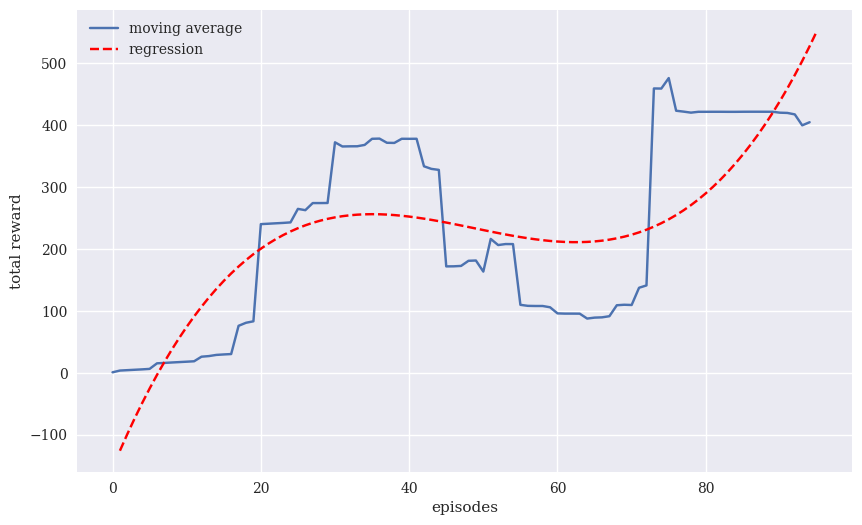

In [19]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

Esto solo va a funcionar si performances y vperformances son iguales, y el codigo no garantiza que siempre pase, por eso abajo hay una forma aproximada de hacer lo mismo

In [20]:
# print(len(x))
# print(len(agent.vperformances))
# print(len(agent.performances))
# plt.figure(figsize=(10, 6))
# x = range(1, len(agent.performances) + 1)
# y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
# y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
# plt.plot(agent.performances[:], label='training')
# plt.plot(agent.vperformances[:], label='validation')
# plt.plot(x, y, 'b--', label='regression (train)')
# plt.plot(x, y_, 'g-.', label='regression (valid)')
# plt.xlabel('episodes')
# plt.ylabel('gross performance')
# plt.legend();

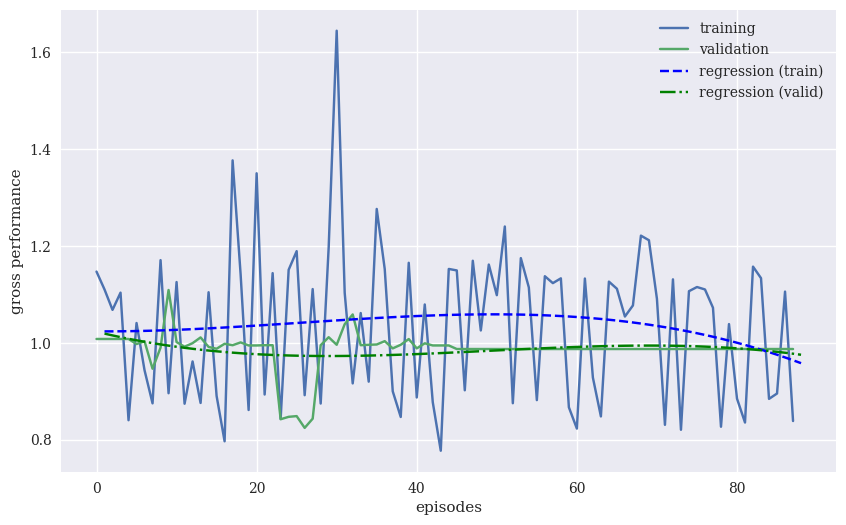

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Asumiendo que agent.performances y agent.vperformances son listas con diferentes longitudes
min_length = min(len(agent.performances), len(agent.vperformances))

x = range(1, min_length + 1)

# Truncar las listas al tamaño de la más corta
performances_truncated = agent.performances[:min_length]
vperformances_truncated = agent.vperformances[:min_length]

# Realizar regresión polinómica para ambas listas truncadas
y = np.polyval(np.polyfit(x, performances_truncated, deg=3), x)
y_ = np.polyval(np.polyfit(x, vperformances_truncated, deg=3), x)

plt.plot(performances_truncated, label='training')
plt.plot(vperformances_truncated, label='validation')
plt.plot(x, y, 'b--', label='regression (train)')
plt.plot(x, y_, 'g-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend()

plt.show()


### Vectorized Backtesting  sin risk management

In [22]:
#
# Vectorized Backtesting of
# Trading Bot (Financial Q-Learning Agent)
#
# (c) Dr. Yves J. Hilpisch
# Artificial Intelligence in Finance
#
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

def reshape(s, env):
    return np.reshape(s, [1, env.lags, env.n_features])

def backtest(agent, env):
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state, env))[0, 0])
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    env.data['s'] = env.data['p'] * env.data['r']* env.leverage

In [23]:
#test
test_env = Finance(symbol, features, window=10, lags=6,
                 leverage=1, min_performance=0.85,
                 start=a+b+c, end=None, mu=None, std=None)
env = test_env
backtest(agent, env)
print(env.data['p'].iloc[env.lags:].value_counts()) #long and shorts positions

0    10763
1       27
Name: p, dtype: int64


In [24]:
# env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [25]:
env.data['r'].describe()

count    10796.000000
mean         0.000027
std          0.003166
min         -0.042470
25%         -0.001273
50%          0.000016
75%          0.001340
max          0.033446
Name: r, dtype: float64

### Event-Based Backtesting sin risk managment

In [26]:
#
# Event-Based Backtesting
# --Base Class (1)
#
# (c) Dr. Yves J. Hilpisch
# Artificial Intelligence in Finance
#


class BacktestingBase:
    def __init__(self, env, model, amount, ptc, ftc, verbose=False):
        self.env = env
        self.model = model
        self.initial_amount = amount
        self.current_balance = amount
        self.ptc = ptc
        self.ftc = ftc
        self.verbose = verbose
        self.units = 0
        self.trades = 0

    def get_date_price(self, bar):
        ''' Returns date and price for a given bar.
        '''
        date = str(self.env.data.index[bar])[:10]
        price = self.env.data[self.env.symbol].iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Prints the current cash balance for a given bar.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance = {self.current_balance:.2f}')

    def calculate_net_wealth(self, price):
        return self.current_balance + self.units * price

    def print_net_wealth(self, bar):
        ''' Prints the net wealth for a given bar
            (cash + position).
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.calculate_net_wealth(price)
        print(f'{date} | net wealth = {net_wealth:.2f}')

    def place_buy_order(self, bar, amount=None, units=None):
        ''' Places a buy order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
            # units = amount / price  # alternative handling
        self.current_balance -= (1 + self.ptc) * \
            units * price + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buy {units} units for {price:.10f}')
            self.print_balance(bar)

    def place_sell_order(self, bar, amount=None, units=None):
        ''' Places a sell order for a given bar and for
            a given amount or number of units.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
            # units = amount / price  # altermative handling
        self.current_balance += (1 - self.ptc) * \
            units * price - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | sell {units} units for {price:.10f}')
            self.print_balance(bar)

    def close_out(self, bar):
        ''' Closes out any open position at a given bar.
        '''
        date, price = self.get_date_price(bar)
        print(50 * '=')
        print(f'{date} | *** CLOSING OUT ***')
        if self.units < 0:
            self.place_buy_order(bar, units=-self.units)
        else:
            self.place_sell_order(bar, units=self.units)
        if not self.verbose:
            print(f'{date} | current balance = {self.current_balance:.2f}')
        perf = (self.current_balance / self.initial_amount - 1) * 100
        print(f'{date} | net performance [%] = {perf:.4f}')
        print(f'{date} | number of trades [#] = {self.trades}')
        print(50 * '=')

In [27]:
env = test_env
tb = TBBacktesterRM(env, agent.model, 10000,
        0.00012, 0, verbose=False)
tb.backtest_strategy(sl=0.015, tsl=0.015, tp=0.05, wait=5)


2023-06-19 | *** START BACKTEST ***
2023-06-19 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0511) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0180) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0163) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0198) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0157) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0180) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0165) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0283) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0190) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0206) ***
---------------------------------------

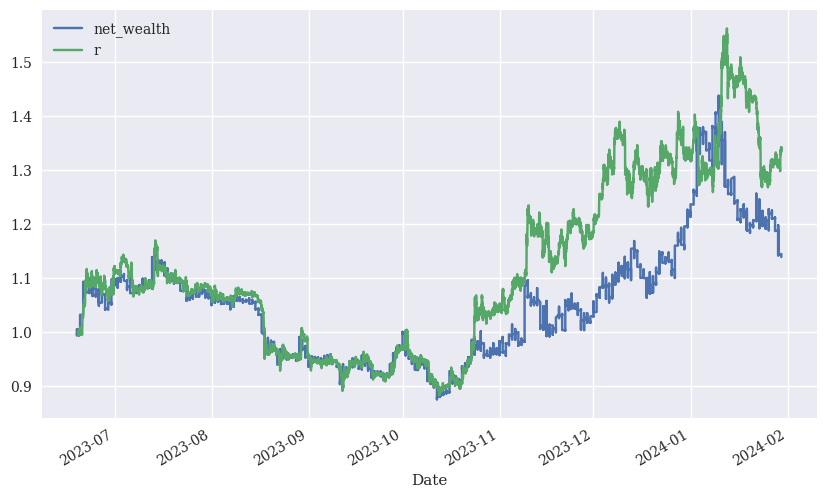

In [28]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10, 6))
tp = env.data[['r']].iloc[env.lags:].cumsum().apply(np.exp)
(tp / tp.iloc[0]).plot(ax=ax);